In [1]:
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import h
from astropy.constants import k_B

mpl.rcParams['text.usetex'] = True

In [3]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2))
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2))
synch_Q_030  = hp.read_map('bp_030_synch_amplitude_Q_00020.fits')
synch_U_030  = hp.read_map('bp_030_synch_amplitude_U_00020.fits')
dust_Q_amps  = np.loadtxt('dust_Q_amplitudes.dat')
dust_U_amps  = np.loadtxt('dust_U_amplitudes.dat')
ame_map      = hp.read_map('/home/daniel/data/planck_products/COM_CompMap_AME-commander_0064_R2.00.fits',field=0)

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [4]:
# Define bands - labels and frequencies
freq         = [28.4, 44.1, 70.3, 22.8, 40.6]
labels       = ['bp\_030','bp\_044','bp\_070','WMAP\_K','WMAP\_Q']

In [5]:
# Planck 2015 2 component AME details
ame_comp1 = [92.,22.8,20.]   #<A_SD>,ref and peak freqs in GHz
ame_comp2 = [18.,40.1,33.35] #<A_SD>,ref and peak freqs in GHz

In [6]:
# Some plotting array of frequencies
x = np.linspace(5,500,1000)

In [7]:
# This approach will be to divide each map by the actual npip26v20 353 (Q or U) map for normalization
# In essence, this means that in our 'units', the npipe6v20 is equal to 1.0 everywhere.

dust_353[0][:] = hp.remove_dipole(dust_353[0][:],gal_cut=75)

synch_Q_scaled = synch_Q_030/dust_353[1][:]
synch_U_scaled = synch_Q_030/dust_353[2][:]

monopole: 640.38  dipole: lon: -96.5856, lat: 46.3103, amp: 3528.12


In [8]:
# The idea here is that if the AME is as polarized as dust, then
# Q_{AME}/Q_{dust,353} = I_{AME}/I_{dust,353} <- cmb corrected of course

I_ame_over_I_353    = ame_map/dust_353[0][:]

In [14]:
# Make signal to noise maps 
s_n_Q        = dust_353[1][:]/dust_353_rms[1][:]
s_n_U        = dust_353[2][:]/dust_353_rms[2][:]
mask_Q       = np.empty(len(s_n_Q))
mask_U       = np.empty(len(s_n_U))

# Write something here about choosing a pixel, or s/n ratio for a sky fraction

sn_lim = float(input('Signal to noise limit: '))

npix = len(synch_Q_030)
Q_masked = 0
U_masked = 0

Signal to noise limit:  10


In [15]:
for i in range(len(s_n_Q)):
    if (np.abs(s_n_Q[i]) > sn_lim):
        mask_Q[i] = 1.0
    else:
        Q_masked += 1
        mask_Q[i] = hp.UNSEEN
        s_n_Q[i]  = hp.UNSEEN

    if (np.abs(s_n_U[i]) > sn_lim):
        mask_U[i] = 1.0
    else:
        U_masked += 1
        mask_U[i] = hp.UNSEEN
        s_n_U[i]  = hp.UNSEEN

In [16]:
# SED functions, all given in units of uK_RJ
def power_law(amp,ref,x,beta):
    return amp*(x/ref)**(beta)

def mbb(amp,ref,x,td,beta):
    z = h.value / (k_B.value*td)
    return amp*(np.exp(z*ref*1e9)-1.0)/(np.exp(x*1e9*z)-1.0)*(x/ref)**(beta+1.0)

# Used to shift the spdust spectrum                                                                                                                                                                                
def sdust(nu, Asd, nu_p, nuref):
    nu_ref = nuref*1e9
    nu_p0 = 30.*1e9
    nu_p *= 1e9
    
    fnu, f = np.loadtxt("../../../ame_spectra/spdust2_cnm.dat", unpack=True)
    fnu *= 1e9
    # MAKE SURE THAT THESE ARE BOTH IN 1e9                                                                                                                                                                         
    scale = nu_p0/nu_p

    f = np.interp(scale*nu*1e9, fnu, f)
    f0 = np.interp(scale*nu_ref, scale*nu*1e9, f) # Value of s at nu_0
    # Move from intensity to uK_RJ
    s_sd = (nu_ref/nu*1e9)**2*f/f0
    return s_sd/np.max(s_sd)

In [17]:
def mask_maps(mask,pol):
    for i in range(len(mask)):
        if (pol == 'Q'):
            if (mask[i] == hp.UNSEEN):
                I_ame_over_I_353[i] = 0.0 
                synch_Q_scaled[i]   = 0.0
        elif (pol == 'U'):
            if (mask[i] == hp.UNSEEN):
                I_ame_over_I_353[i] = 0.0 
                synch_U_scaled[i]   = 0.0
        else:
            print("Unusable pol type (use 'Q' or 'U').")

In [19]:
spdust_tot  = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
spdust_tot  = spdust_tot/np.max(spdust_tot)

In [20]:
mask_maps(mask_Q,'Q')
mask_maps(mask_U,'U')
spdust_tot *= np.mean(I_ame_over_I_353)

In [21]:
ame_col = ['yellow','gold','orange','darkorange','orangered']

In [28]:
def plot_Q_Q353():
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(np.mean(synch_Q_scaled),30.0,x,-3.1),color='green',label='Synch')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label='Thermal Dust')
    ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 0.5*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 0.25*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 0.1*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 0.05*p_{\mathrm{dust}}^{max}$')
    for j in range(len(freq)):
        if dust_Q_amps[0][j] == 0.0:
            continue
        else:
            ax.scatter(freq[j],dust_Q_amps[0,j],label=labels[j])
    ax.set_xlim([5,200])
    ax.set_ylim([3e-6,3e1])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('AME Pol v15 - Q Amplitudes',size=20)
    ax.set_ylabel(r'$Q/Q_{353}$',size=20)
    ax.set_xlabel('Frequency [GHz]',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=30)
    plt.rc('xtick',labelsize=30)
#     plt.savefig('sed_fgs_Q353',dpi=300,bbox_inches='tight')
    plt.show()

def plot_U_U353():
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(np.mean(synch_U_scaled),30.0,x,-3.1),color='green',label='Synch')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label='Thermal Dust')
    ax.plot(x,spdust_tot,color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.5,color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 0.5*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.25,color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 0.25*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.1,color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 0.1*p_{\mathrm{dust}}^{max}$')
    ax.plot(x,spdust_tot*0.05,color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 0.05*p_{\mathrm{dust}}^{max}$')
    for j in range(len(freq)):
        if dust_U_amps[0][j] == 0.0:
            continue
        else:
            ax.scatter(freq[j],dust_U_amps[0,j],label=labels[j])
    ax.set_xlim([5,200])
    ax.set_ylim([3e-6,3e1])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('AME Pol v15 - U Amplitudes',size=20)
    ax.set_ylabel(r'$U/U_{353}$',size=20)
    ax.set_xlabel('Frequency [GHz]',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=30)
    plt.rc('xtick',labelsize=30)
#     plt.savefig('sed_fgs_U353',dpi=300,bbox_inches='tight')
    plt.show()

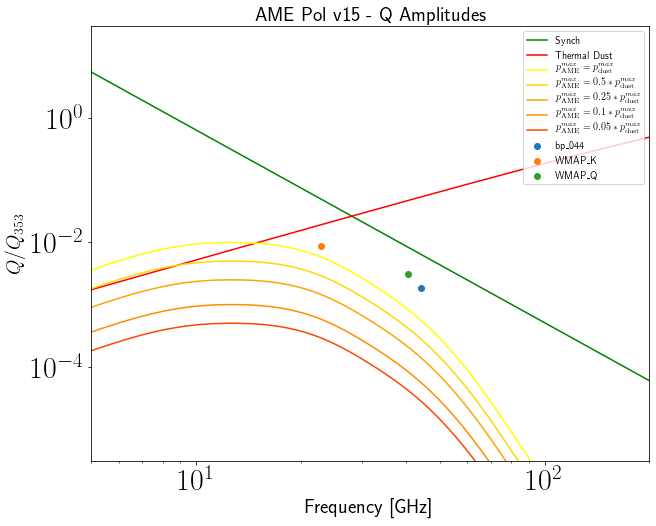

In [29]:
plot_Q_Q353()

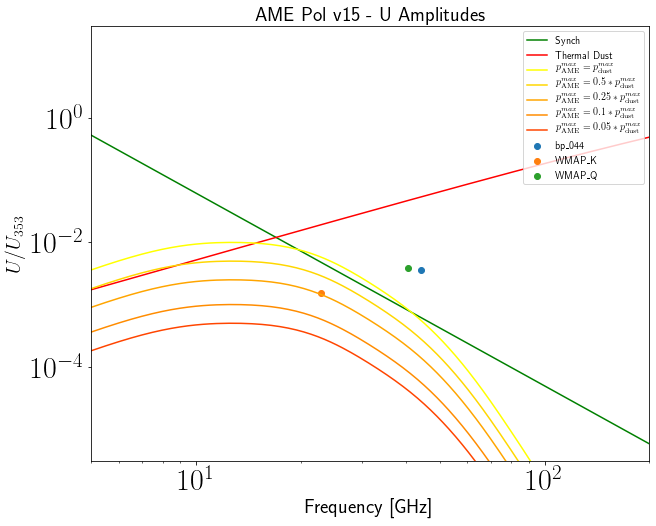

In [26]:
plot_U_U353()